## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [19]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

from tvtk.api import tvtk
from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects


### Data paths

In [10]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
common_space = data_dir + 'common_space/fsaverage/'
results_dir = data_dir + 'results/'
brainmaps_dir = results_dir + 'brainmaps/'
demograph_file = 'ABIDE_Phenotype.csv'
sm_perf_file = 'atlas_sm_perf_sanitycheck_DX_GROUP_roi_logit_QC_auto_N_959.pkl'

### Global Vars

In [11]:
subject_ID_col = 'SubjID'

### Load data

In [12]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# # Results
results_type = 'atlas' # atlas or pipeline
stat_measure = 'p_val' # p_val or p_val_corr

if results_type == 'pipeline':
    stat_perf = pd.read_pickle(results_dir + sm_perf_file)
        
else:
    with open(results_dir + sm_perf_file, 'rb') as handle:
        stat_perf = pickle.load(handle)
        


### Statistical plots 

Plots based on 959 subjects
Top 5 most significant regions            roi      coef     t_val     p_val  p_val_corr
183   R_V2_ROI  2.043860  4.050276  0.000051    0.016204
0     L_V1_ROI  1.707668  3.916026  0.000090    0.016204
3     L_V2_ROI  1.623558  3.445970  0.000569    0.068282
234  R_6mp_ROI -0.916930 -2.977385  0.002907    0.261647
341  R_31a_ROI  0.699860  2.862751  0.004200    0.267506


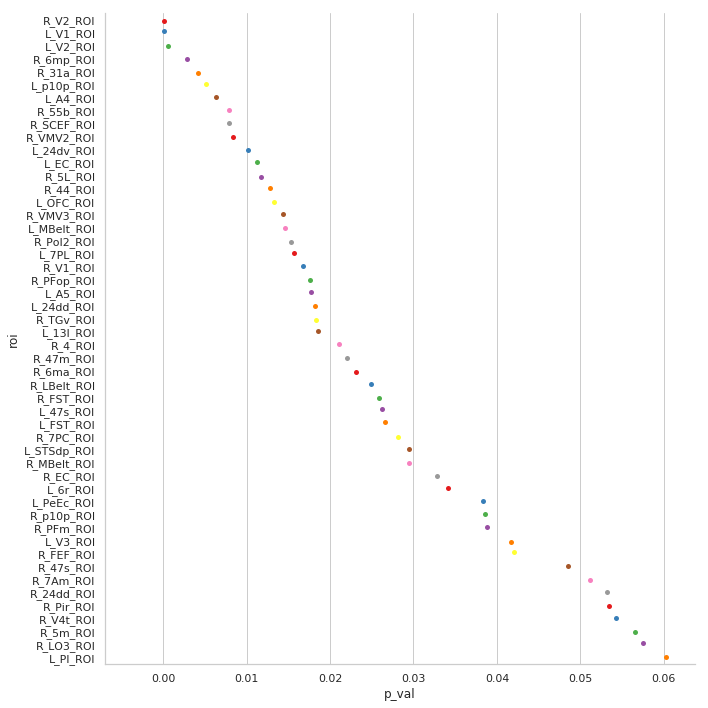

In [13]:
aparc = 'Glasser' #aparc #Destrieux #Glasser
top_rois = 50
subx = sm_perf_file.rsplit('_',1)[1].split('.',1)[0]
print('Plots based on {} subjects'.format(subx))

if results_type == 'pipeline':
    plot_df = stat_perf.sort_values(by=[stat_measure]).head(top_rois)
    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',hue='pipeline',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");

else:
    plot_df = stat_perf[aparc].sort_values(by=['p_val']).head(top_rois)

    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");
        
print('Top 5 most significant regions {}'.format(plot_df.head(5)))

## PySurfer plots

In [14]:
# Plot configs

p_thresh = 0.05

if stat_measure == 'p_val':
    mult_comp = 'no_FDR'
elif stat_measure == 'p_val_corr':
    mult_comp = 'FDR'
else:
    print('unknown multiple comparison correction')
    mult_comp = 'unknown'

    
sm_perf_filename_split = sm_perf_file.split('.',1)[0].rsplit('_',2) 
brainmap_subdir = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2]

save_dir = brainmaps_dir + brainmap_subdir + '/'

if results_type == 'pipeline':
    pipes = ['fs51','fs53','fs60','civet','ants']
    aparcs = ['aparc']
    aparc = 'aparc' #For aggregating result cell 
    aparc_file = '.aparc.annot'
else:
    pipes = ['fs60']
    pipe = 'fs60' #For aggregating result cell 
    aparcs = ['aparc', 'Destrieux', 'Glasser']
    
# Pysurfer parameters
surf = 'inflated' #'white' #"inflated"
views = ['lateral','medial']

### test out code for vertex plotting

In [181]:
sample_file = '/home/nikhil/projects/CT_reproduce/data/fs60_vertex_out/abide_fs60_vout_fwhm0_lh_SubjectIDFormatted_test20.csv'
sample_vdata = pd.read_csv(sample_file)
print(sample_vdata.shape)

hemi = 'lh'
view = 'medial'
surf = 'inflated'

(19, 163843)


In [187]:
save_path = './test_brain.jpg'
thickness_vals = sample_vdata.values[1,1:]>3.0  #ignore header and index
plot_surface_vertices(common_space,thickness_vals,hemi,surf,view,cmap,save_path)

colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)


In [184]:
def plot_surface_vertices(common_space,morph_data,hemi,surf,view,cmap,save_path):
    b = Brain(common_space, hemi, surf, background="white",views=view)
    b.add_data(morph_data,colormap=cmap, alpha=.9, colorbar=True)
    b.save_image(save_path)

In [15]:
# Plot loops 
plot_style = {'colormap':'icefire','center':0}
for pipe in pipes:
    for aparc in aparcs:
        if results_type == 'pipeline':
            stat_df = stat_perf[stat_perf['pipeline']==pipe]
        else:
            stat_df = stat_perf[aparc]

        signific_rois = stat_df[stat_df[stat_measure] < p_thresh]['roi'].values
        signific_betas = stat_df[stat_df[stat_measure] < p_thresh]['coef'].values
        print('Number of signficant ROIs {}'.format(len(signific_rois)))

        plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(signific_rois,aparc,signific_betas)
        print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))
        
        if aparc == 'Glasser':
            aparc_file = '.HCP-MMP1.annot' 
        elif aparc == 'Destrieux':
            aparc_file = '.aparc.a2009s.annot' 
        elif aparc in ['aparc', 'DKT']:
            aparc_file = '.aparc.annot'
        else:
            aparc_file = ''
            print('Unknown cortical parcellation')

        for hemi in ['lh','rh']:
            if hemi=='lh':
                signific_rois = plot_regions_L
                betas = betas_L
            elif hemi=='rh':
                signific_rois = plot_regions_R
                betas = betas_R
            else: 
                print('Unknown hemisphere parameter')

            for view in views:
                title = '_{}_{}_{}_{}_{}_{}_N_{}'.format(pipe,aparc,surf,hemi,view,stat_measure,subx)
                brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                                save_dir,title,view,betas,plot_style)
                time.sleep(5) #Mayavi messes up if called to quickly
                

Number of signficant ROIs 14
plot regions 
left: ['cuneus', 'entorhinal', 'lateraloccipital', 'lingual', 'medialorbitofrontal', 'pericalcarine', 'posteriorcingulate', 'superiortemporal'], 
right: ['entorhinal', 'lateraloccipital', 'lingual', 'paracentral', 'precentral', 'transversetemporal']
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 8
atlas: .aparc.annot, signficant roi count: {-0.5892937243274133: 1102, 0.0: 135424, 1.2677704875319804: 6379, 0.8302625167993366: 7271, 1.111817132799413: 2653, 1.268035214757747: 4205, 1.2776007490500911: 1912, 0.9008417254896998: 1630, 0.8676785260119114: 3266}
colormap divergent: center=0.00e+00, [0.00e+00, 6.39e-01, 1.28e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_sanitycheck_DX_GROUP_roi_logit_QC_auto_no_FDR_N_959/surf_fs60_aparc_inflated_lh_lateral_p_val_N_959.png
number of total vertices 163842 and ROIs 36
Using beta

Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_sanitycheck_DX_GROUP_roi_logit_QC_auto_no_FDR_N_959/surf_fs60_Glasser_inflated_lh_medial_p_val_N_959.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 25
atlas: .HCP-MMP1.annot, signficant roi count: {-0.9169298958197951: 1454, -0.8455084649469684: 3855, 2.0438597584556155: 2991, -0.5981497657782056: 850, 1.0457824604260562: 4178, -0.3793739350392321: 456, 0.6998600706886058: 367, -0.6121299802324902: 401, -0.7529214417603204: 904, -0.6733436052158195: 695, -0.5396388260993554: 294, -0.6446971486755818: 421, -0.7125652215681318: 875, 0.5593454893343826: 457, 0.0: 136348, -0.6597466817309381: 1217, -0.45950379185973356: 666, -0.5485192317247993: 735, 0.720271244110888: 340, -0.7951766230600372: 2349, 0.6272075202243445: 454, 0.7428589022037364: 352, -0.48082620802150117: 716, 0.640140861771785: 640, -0.5026688774972704: 817, -0.

### Aggregate results

In [16]:
df_agg = aggregate_perf(stat_perf,stat_measure,results_type)
agg_rois = df_agg['roi'].values
agg_betas = df_agg['rank'].values
print('Number of signficant ROIs {}'.format(len(agg_rois)))
plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

plot_style = {'colormap':plt.get_cmap('Set1'),'range':[0,5]}
for hemi in ['lh','rh']:
    if hemi=='lh':
        signific_rois = plot_regions_L
        betas = betas_L
    elif hemi=='rh':
        signific_rois = plot_regions_R
        betas = betas_R
    else: 
        print('Unknown hemisphere parameter')

    for view in views:
        title = '_{}_{}_{}_{}_{}_{}_N_{}'.format('agg',aparc,surf,hemi,view,stat_measure,subx)
        brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                        save_dir,title,view,betas,plot_style)

KeyError: 'p_val'

### Create plot montage

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_sanitycheck_DX_GROUP_roi_logit_QC_auto_no_FDR_N_959/
Found 12 images


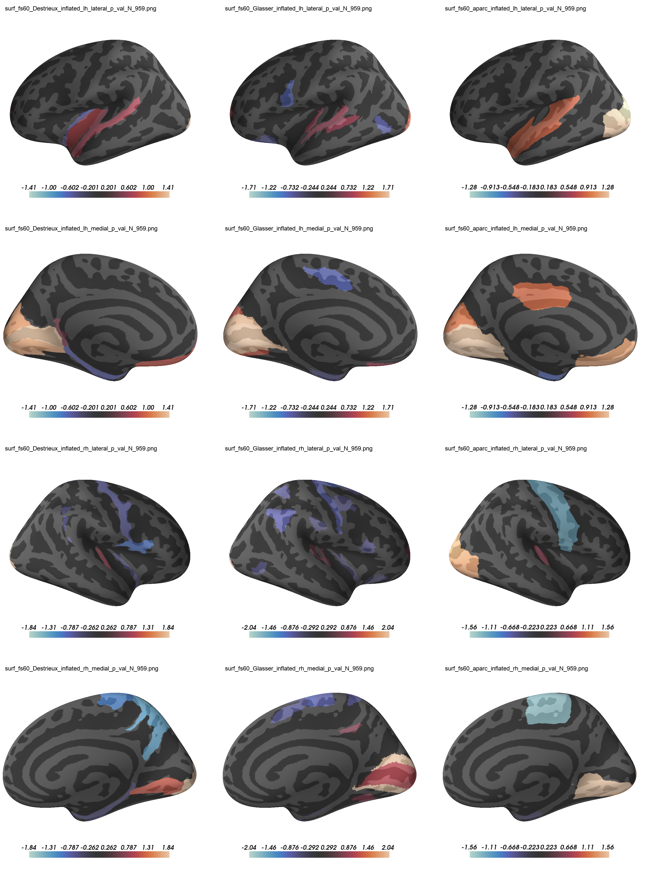

In [17]:
#plot_dir = brainmaps_dir + 'atlas_sm_perf_DX_GROUP_QC_gleb_FDR_N_225/'
plot_dir = save_dir
montage_im = createImageMontage(plot_dir)
montage_im